### Imports

In [12]:
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from imutils import contours
import os
import glob

### Clear Indiviual Char Directory

In [13]:
files = glob.glob('./characters/*')
for f in files:
    os.remove(f)

### Load Image and Split Into Individual Chars

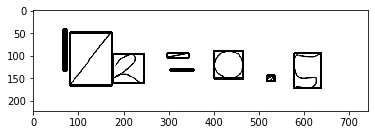

In [14]:
# For now, the image needs to have a background. 
img = cv2.imread("test00.png")

# Convert the image to grayscale
# findContours() requires the image to be binary
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold image
_, thresh = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV) 

# Erode then dialate (if image in noisy use this)
# morphed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((2,2)))

# Dialate image
morphed = cv2.dilate(thresh, np.ones((4,4), np.uint8), iterations=2)

# Find contours
cnts, _ = cv2.findContours(thresh.copy(), 
                               cv2.RETR_EXTERNAL, 
                               cv2.CHAIN_APPROX_SIMPLE)

# Sort contours (left-right)
cnts = contours.sort_contours(cnts, method="left-to-right")[0]

# Iterate through contours
i = 0
for cnt in cnts:
    
    # NOTE: We have no check on what is a valid contour,
    # meaning, any stray mark will be treated as an
    # individual character
    
    # Identify rectangle boundary
    (x, y, w, h) = cv2.boundingRect(cnt)
    
    # Save character
    # NOTE: Before saving we could resize the image here to
    # fit training set features
    cv2.imwrite("./characters/char" + str(i) + ".png", img[y:y+h,x:x+w])
    i += 1
    
    # Draw rectangle boundary
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
    
plt.imshow(img, cmap='Greys_r')
plt.show()